# 10.11日 23：08更新
# 10.13日 11:34更新

In [23]:
import torch
import torch.nn as nn
import torch.nn.functional as F
class MyFCNet(nn.Module):

    def __init__(self, l1_reg=0.01):
        super(MyFCNet, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=4, out_channels=100, kernel_size=(6, 1))
        self.maxpool1 = nn.MaxPool2d(kernel_size=(2, 1))
        self.conv2 = nn.Conv2d(100, 200, kernel_size=(5, 1))
        self.maxpool2 = nn.MaxPool2d(kernel_size=(2, 1))
        self.flatten = nn.Flatten()
        self.fc1 = nn.Linear(800, 128)
        self.dropout1 = nn.Dropout(0.3)
        self.fc2 = nn.Linear(128, 64)
        self.dropout2 = nn.Dropout(0.3)
        self.fc3 = nn.Linear(64, 32)
        self.fc4 = nn.Linear(32, 1)
        self.l1_reg = l1_reg

    def forward(self, x, targets=None, epoch=None):
        x = torch.relu(self.conv1(x))
        x = self.maxpool1(x)
        x = torch.relu(self.conv2(x))
        x = self.maxpool2(x)
        x = self.flatten(x)
        x = torch.relu(self.fc1(x))
        x = self.dropout1(x)
        x = torch.relu(self.fc2(x))
        x = self.dropout2(x)
        x = torch.relu(self.fc3(x))
        x = self.fc4(x)
        if self.l1_reg > 0:
            l1_loss = torch.tensor(0.0, requires_grad=True)
            for name, param in self.named_parameters():
                if 'weight' in name:
                    l1_loss = l1_loss + torch.norm(param, p=1)
            x = x + self.l1_reg * l1_loss
        return x
class MyFCNetEnsemble(nn.Module):

    def __init__(self, l1_reg=0.01):
        super(MyFCNetEnsemble, self).__init__()
        self.fcnet1 = MyFCNet(l1_reg=l1_reg)
        self.fcnet2 = MyFCNet(l1_reg=l1_reg)
        # 再加一层MyFCNet
        self.fcnet3 = MyFCNet(l1_reg=l1_reg)
        self.fc = nn.Linear(3, 1)
    def forward(self, x, targets=None, epoch=None):
        x1 = self.fcnet1(x)
        x2 = self.fcnet2(x)
        x3 = self.fcnet3(x)
        x = torch.cat((x1,x2,x3), dim=1)
        x = self.fc(x)
        return x
# class MyLSTMNet(nn.Module):
#     def __init__(self):
#         super(MyLSTMNet, self).__init__()
     
#         self.lstm = nn.LSTM(4,64, 2, batch_first=True)
#         self.fc = nn.Linear(64, 1)

#     def forward(self, x,targets=None, epoch=None):
#         h0 = torch.zeros(2, x.size(0), 64).to(x.device)
#         c0 = torch.zeros(2, x.size(0), 64).to(x.device)
#         out, _ = self.lstm(x, (h0, c0))
#         out = self.fc(out[:, -1, :])  # 仅使用最后一个时间步的输出
#         return out

# # 定义模型参数
# input_size = 4  # 输入特征的维度，等于通道数
# hidden_size = 64  # LSTM隐藏层的单元数
# num_layers = 2  # LSTM层的数量
# output_size = 1  # 输出整数数值
# def lstmnet1(**kwargs):
#     return MyLSTMNet()
def fcnet1(**kwargs):
    return MyFCNetEnsemble(**kwargs)

# Define the loss functions. Here we only need the L1 loss: |f(x) - y|.

In [24]:
# loss.py: Define the loss functions (here we only need the L1 loss)
import torch
import torch.nn.functional as F

def weighted_mse_loss(inputs, targets, weights=None):
    loss = (inputs - targets) ** 2
    if weights is not None:
        loss *= weights.expand_as(loss)
    loss = torch.mean(loss)
    return loss

def weighted_l1_loss(inputs, targets, weights=None):
    loss = F.l1_loss(inputs, targets, reduction='none')
    if weights is not None:
        loss *= weights.expand_as(loss)
    loss = torch.mean(loss)
    return loss

def weighted_focal_mse_loss(inputs, targets, weights=None, activate='sigmoid', beta=.2, gamma=1):
    loss = (inputs - targets) ** 2
    loss *= (torch.tanh(beta * torch.abs(inputs - targets))) ** gamma if activate == 'tanh' else \
        (2 * torch.sigmoid(beta * torch.abs(inputs - targets)) - 1) ** gamma
    if weights is not None:
        loss *= weights.expand_as(loss)
    loss = torch.mean(loss)
    return loss

def weighted_focal_l1_loss(inputs, targets, weights=None, activate='sigmoid', beta=.2, gamma=1):
    loss = F.l1_loss(inputs, targets, reduction='none')
    loss *= (torch.tanh(beta * torch.abs(inputs - targets))) ** gamma if activate == 'tanh' else \
        (2 * torch.sigmoid(beta * torch.abs(inputs - targets)) - 1) ** gamma
    if weights is not None:
        loss *= weights.expand_as(loss)
    loss = torch.mean(loss)
    return loss

def weighted_huber_loss(inputs, targets, weights=None, beta=1.):
    l1_loss = torch.abs(inputs - targets)
    cond = l1_loss < beta
    loss = torch.where(cond, 0.5 * l1_loss ** 2 / beta, l1_loss - 0.5 * beta)
    if weights is not None:
        loss *= weights.expand_as(loss)
    loss = torch.mean(loss)
    return loss


# Define some utility functions (not the focus of this course).

In [25]:
# utils.py: Define some utility functions (not the focus of this course).
import os
import shutil
import torch
import numpy as np
from scipy.ndimage import gaussian_filter1d
from scipy.signal.windows import triang
import matplotlib.pyplot as plt
class AverageMeter(object):
    def __init__(self, name, fmt=':f'):
        self.name = name
        self.fmt = fmt
        self.reset()

    def reset(self):
        self.val = 0
        self.avg = 0
        self.sum = 0
        self.count = 0

    def update(self, val, n=1):
        self.val = val
        self.sum += val * n
        self.count += n
        self.avg = self.sum / self.count

    def __str__(self):
        fmtstr = '{name} {val' + self.fmt + '} ({avg' + self.fmt + '})'
        return fmtstr.format(**self.__dict__)

class ProgressMeter(object):
    def __init__(self, num_batches, meters, prefix=""):
        self.batch_fmtstr = self._get_batch_fmtstr(num_batches)
        self.meters = meters
        self.prefix = prefix

    def display(self, batch):
        entries = [self.prefix + self.batch_fmtstr.format(batch)]
        entries += [str(meter) for meter in self.meters]
        print('\t'.join(entries))

    @staticmethod
    def _get_batch_fmtstr(num_batches):
        num_digits = len(str(num_batches // 1))
        fmt = '{:' + str(num_digits) + 'd}'
        return '[' + fmt + '/' + fmt.format(num_batches) + ']'

def query_yes_no(question):
    """ Ask a yes/no question via input() and return their answer. """
    valid = {"yes": True, "y": True, "ye": True, "no": False, "n": False}
    prompt = " [Y/n] "

    while True:
        print(question + prompt, end=':')
        choice = input().lower()
        if choice == '':
            return valid['y']
        elif choice in valid:
            return valid[choice]
        else:
            print("Please respond with 'yes' or 'no' (or 'y' or 'n').\n")

def prepare_folders(args):
    folders_util = [args.store_root, os.path.join(args.store_root, args.store_name)]
    if os.path.exists(folders_util[-1]) and not args.resume and not args.evaluate:
        if query_yes_no('overwrite previous folder: {} ?'.format(folders_util[-1])):
            shutil.rmtree(folders_util[-1])
            print(folders_util[-1] + ' removed.')
        else:
            raise RuntimeError('Output folder {} already exists'.format(folders_util[-1]))
    for folder in folders_util:
        if not os.path.exists(folder):
            print(f"===> Creating folder: {folder}")
            os.mkdir(folder)

def adjust_learning_rate(optimizer, epoch, args):
    lr = args.lr
    for milestone in args.schedule:
        lr *= 0.1 if epoch >= milestone else 1.
    for param_group in optimizer.param_groups:
        param_group['lr'] = lr

# def save_checkpoint(args, state, is_best, prefix=''):
#     filename = f"{args.store_root}/{args.store_name}/{prefix}ckpt.pth.tar"
#     torch.save(state, filename)
#     if is_best:
#         print("===> Saving current best checkpoint...")
#         shutil.copyfile(filename, filename.replace('pth.tar', 'best.pth.tar'))

def calibrate_mean_var(matrix, m1, v1, m2, v2, clip_min=0.1, clip_max=10):
    if torch.sum(v1) < 1e-10:
        return matrix
    if (v1 == 0.).any():
        valid = (v1 != 0.)
        factor = torch.clamp(v2[valid] / v1[valid], clip_min, clip_max)
        matrix[:, valid] = (matrix[:, valid] - m1[valid]) * torch.sqrt(factor) + m2[valid]
        return matrix

    factor = torch.clamp(v2 / v1, clip_min, clip_max)
    return (matrix - m1) * torch.sqrt(factor) + m2

def get_lds_kernel_window(kernel, ks, sigma):
    assert kernel in ['gaussian', 'triang', 'laplace']
    half_ks = (ks - 1) // 2
    if kernel == 'gaussian':
        base_kernel = [0.] * half_ks + [1.] + [0.] * half_ks
        kernel_window = gaussian_filter1d(base_kernel, sigma=sigma) / max(gaussian_filter1d(base_kernel, sigma=sigma))
    elif kernel == 'triang':
        kernel_window = triang(ks)
    else:
        laplace = lambda x: np.exp(-abs(x) / sigma) / (2. * sigma)
        kernel_window = list(map(laplace, np.arange(-half_ks, half_ks + 1))) / max(map(laplace, np.arange(-half_ks, half_ks + 1)))

    return kernel_window


# Define the data iterator (data loader).

In [26]:
from scipy.ndimage import convolve1d
import os
import numpy as np
from torch.utils import data
import pandas as pd
class DNA_loader(data.Dataset):
    def __init__(self, labels,dna, split='train', reweight='none',
                 lds=False, lds_kernel='gaussian', lds_ks=5, lds_sigma=2):
        self.split = split
        self.labels= labels
        
        self.dna = self.seq2onehot(dna)
        
        self.weights = self.weights = self._prepare_weights(reweight=reweight, lds=lds, lds_kernel=lds_kernel, lds_ks=lds_ks, lds_sigma=lds_sigma)
        
    def __len__(self):
        return self.labels.shape[0]
    


    def __getitem__(self, index):
        index = index % self.labels.shape[0]
        feature = np.transpose(self.dna[index], (2, 0, 1))
        label = self.labels[index]
        weight = np.asarray([self.weights[index]]).astype('float32') if self.weights is not None else np.asarray([np.float32(1.)])
        return feature, weight, label
    

    
    def seq2onehot(self,seq):     #convert the cRBS sequences to one-hot encoding
        module = np.array([[[1,0,0,0]],
                           [[0,1,0,0]],
                           [[0,0,1,0]],
                           [[0,0,0,1]]])
        i = 0
        cRBS_onehot = []
        for i in seq:
            tmp = []
            for item in i:
                if item == 't' or item == 'T':
                    tmp.append(module[0])
                elif item == 'c' or item == 'C':
                    tmp.append(module[1])
                elif item == 'g' or item == 'G':
                    tmp.append(module[2])
                elif item == 'a' or item == 'A':
                    tmp.append(module[3])
                else:
                    tmp.append([[0,0,0,0]])
            cRBS_onehot.append(tmp)
        cRBS_onehot=np.array(cRBS_onehot).astype('float32')
        return cRBS_onehot

    def _prepare_weights(self, reweight, max_target=40, lds=False, lds_kernel='gaussian', lds_ks=5, lds_sigma=2):
        assert reweight in {'none', 'inverse', 'sqrt_inv'}
        assert reweight != 'none' if lds else True, \
            "Set reweight to \'sqrt_inv\' (default) or \'inverse\' when using LDS"
        value_dict = {x: 0 for x in range(max_target)}
        labels = self.labels.tolist()
        # mbr   
        for label in labels:
            value_dict[min(max_target - 1, int(label))] += 1
        if reweight == 'sqrt_inv':
            value_dict = {k: np.sqrt(v) for k, v in value_dict.items()}
        elif reweight == 'inverse':
            value_dict = {k: np.clip(v, 5, 1000) for k, v in value_dict.items()}  # clip weights for inverse re-weight
        num_per_label = [value_dict[min(max_target - 1, int(label))] for label in labels]
        if not len(num_per_label) or reweight == 'none':
            return None
        print(f"Using re-weighting: [{reweight.upper()}]")
        if lds:
            lds_kernel_window = get_lds_kernel_window(lds_kernel, lds_ks, lds_sigma)
            print(f'Using LDS: [{lds_kernel.upper()}] ({lds_ks}/{lds_sigma})')
            smoothed_value = convolve1d(
                np.asarray([v for _, v in value_dict.items()]), weights=lds_kernel_window, mode='constant')
            num_per_label = [smoothed_value[min(max_target - 1, int(label))] for label in labels]
        weights = [np.float32(1 / x) for x in num_per_label]
        scaling = len(weights) / np.sum(weights)
        weights = [scaling * x for x in weights]
        return weights

# Set up some default configurations.

In [27]:
# train.py, Part 1: Set up some default configurations.
import time
import argparse
#import logging
from tqdm import tqdm
import pandas as pd
from collections import defaultdict
from scipy.stats import gmean

import torch.nn as nn
import torch.backends.cudnn as cudnn
from torch.utils.data import DataLoader
from sklearn.model_selection import train_test_split
#from resnet import resnet50
# from fcnet import fcnet1
# from loss import *
# from datasets import BostonHousing
# from utils import *

import os
os.environ["KMP_WARNINGS"] = "FALSE"

parser = argparse.ArgumentParser(formatter_class=argparse.ArgumentDefaultsHelpFormatter)
# CPU only
parser.add_argument('--cpu_only', action='store_true', default=False, help='whether to use CPU only')
# imbalanced related
# LDS
parser.add_argument('--lds', action='store_true', default=False, help='whether to enable LDS')
parser.add_argument('--lds_kernel', type=str, default='gaussian',
                    choices=['gaussian', 'triang', 'laplace'], help='LDS kernel type')
parser.add_argument('--lds_ks', type=int, default=9, help='LDS kernel size: should be odd number')
parser.add_argument('--lds_sigma', type=float, default=1, help='LDS gaussian/laplace kernel sigma')

# re-weighting: SQRT_INV / INV
parser.add_argument('--reweight', type=str, default='none', choices=['none', 'sqrt_inv', 'inverse'], help='cost-sensitive reweighting scheme')

# training/optimization related
parser.add_argument('--dataset', type=str, default='bostonhousing', choices=['imdb_wiki', 'agedb'], help='dataset name')
parser.add_argument('--data_dir', type=str, default='./housing.data', help='data directory')
parser.add_argument('--model', type=str, default='fcnet1', help='model name')
parser.add_argument('--store_root', type=str, default='checkpoint', help='root path for storing checkpoints, logs')
parser.add_argument('--store_name', type=str, default='', help='experiment store name')
parser.add_argument('--gpu', type=int, default=None)
parser.add_argument('--optimizer', type=str, default='adam', choices=['adam', 'sgd'], help='optimizer type')
parser.add_argument('--loss', type=str, default='mse', choices=['mse', 'l1', 'focal_l1', 'focal_mse', 'huber'], help='training loss type')
parser.add_argument('--lr', type=float, default=1e-2, help='initial learning rate')
parser.add_argument('--epoch', type=int, default=1000, help='number of epochs to train')
parser.add_argument('--momentum', type=float, default=0.9, help='optimizer momentum')
parser.add_argument('--weight_decay', type=float, default=1e-4, help='optimizer weight decay')
parser.add_argument('--schedule', type=int, nargs='*', default=[100,300,500,700,], help='lr schedule (when to drop lr by 10x)')
#parser.add_argument('--batch_size', type=int, default=256, help='batch size')
parser.add_argument('--batch_size', type=int, default=256, help='batch size')
parser.add_argument('--print_freq', type=int, default=10, help='logging frequency')
parser.add_argument('--img_size', type=int, default=224, help='image size used in training')
parser.add_argument('--workers', type=int, default=32, help='number of workers used in data loading')
# checkpoints
parser.add_argument('--resume', type=str, default='', help='checkpoint file path to resume training')
parser.add_argument('--evaluate', action='store_true', help='evaluate only flag')

parser.set_defaults(augment=True)
# ss
args, unknown = parser.parse_known_args()


In [28]:
# args.cpu_only = True # Use CPU to train/test models

# Train 4 different models using the 4 options below

In [29]:
# # Option 1: To train the basic model, use the default setting, don't need to do anything
# args.reweight = 'none'
# args.lds = False

In [30]:
# # Option 2: To train the inverse weighting model:
# args.reweight = 'inverse'

In [31]:
# # Option 3: To train the sqrt_inverse weighting model:
# args.reweight = 'sqrt_inv'

In [32]:
# Option 4: To train the Label Distribution Smoothing (LDS) model:
args.reweight = 'sqrt_inv'
args.lds = True
args.lds_kernel = 'gaussian'
args.lds_ks = 5 # 5
args.lds_sigma = 2 # 2

# Train/Evaluate the model.

=====> Preparing data...
Using re-weighting: [INVERSE]
Using LDS: [GAUSSIAN] (10/2)
Using re-weighting: [INVERSE]
Using LDS: [GAUSSIAN] (5/2)
Using re-weighting: [INVERSE]
Using LDS: [GAUSSIAN] (5/2)
Training data size: 16639
Validation data size: 2080
Test data size: 2080
=====> Building model...


/home/ly534/anaconda3/envs/pytorch_demo/lib/python3.8/site-packages/torch/utils/data/dataloader.py:560: UserWarning: This DataLoader will create 32 worker processes in total. Our suggested max number of worker in current system is 24, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


Epoch: [0][ 0/65]	Time   0.55 (  0.55)	Data 0.5436 (0.5436)	Loss (MSE) 61130.723 (61130.723)
Epoch: [0][10/65]	Time   0.01 (  0.07)	Data 0.0000 (0.0579)	Loss (MSE) 4185.846 (14616.213)
Epoch: [0][20/65]	Time   0.00 (  0.04)	Data 0.0000 (0.0303)	Loss (MSE) 238.718 (8340.141)
Epoch: [0][30/65]	Time   0.00 (  0.03)	Data 0.0000 (0.0206)	Loss (MSE) 40.749 (5717.704)
Epoch: [0][40/65]	Time   0.00 (  0.02)	Data 0.0000 (0.0156)	Loss (MSE) 25.368 (4335.327)
Epoch: [0][50/65]	Time   0.00 (  0.02)	Data 0.0000 (0.0125)	Loss (MSE) 10.546 (3488.127)
Epoch: [0][60/65]	Time   0.00 (  0.01)	Data 0.0000 (0.0105)	Loss (MSE) 10.076 (2918.170)
Val: [0/9]	Time  0.537 ( 0.537)	Loss (MSE) 2.150 (2.150)	Loss (L1) 0.653 (0.653)
 * Overall: MSE 1.847	L1 0.585	G-Mean 0.272
 * Many: MSE 2.259	L1 1.033	G-Mean 0.905
 * Median: MSE 2.140	L1 1.398	G-Mean 1.343
 * Low: MSE 0.023	L1 0.152	G-Mean 0.152
Best MSE Loss: 1.847
Epoch #0: Train loss [2739.2797]; Val loss: MSE [1.8474], L1 [0.5853], G-Mean [0.2722]
Epoch: [1][ 

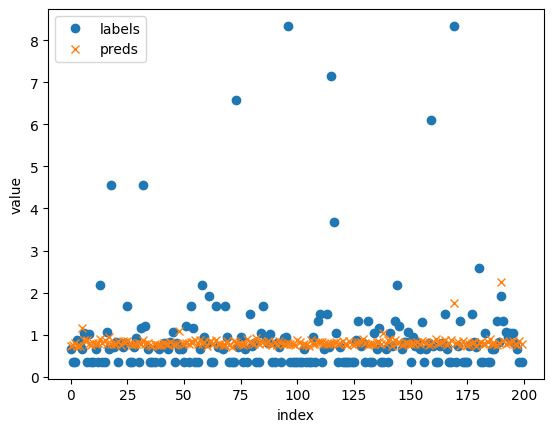

In [33]:
# train.py Part 2: Train/Evaluate the model.
args.store_name = ''
args.start_epoch, args.best_loss = 0, 1e5

# if len(args.store_name):
#     args.store_name = f'_{args.store_name}'
# if not args.lds and args.reweight != 'none':
#     args.store_name += f'_{args.reweight}'
# if args.lds:
#     args.store_name += f'_lds_{args.lds_kernel[:3]}_{args.lds_ks}'
#     if args.lds_kernel in ['gaussian', 'laplace']:
#         args.store_name += f'_{args.lds_sigma}'
# args.store_name = f"{args.dataset}_{args.model}{args.store_name}_{args.optimizer}_{args.loss}_{args.lr}_{args.batch_size}"

# prepare_folders(args)

# print(f"Args: {args}")
# print(f"Store name: {args.store_name}")
import torch
from torch.utils.tensorboard import SummaryWriter

def main():
    if args.gpu is not None:
        print(f"Use GPU: {args.gpu} for training") 
   
    print('=====> Preparing data...')
    x_train=pd.read_excel('data/promoter_w_20799.xlsx',header=None).to_numpy().reshape(-1)
    y_train=pd.read_excel('data/mapped_labels.xlsx',header=None).to_numpy().reshape(-1)

    train_data, temp_data, train_labels, temp_labels = train_test_split(x_train, y_train, test_size=0.2, random_state=42)
    val_data, test_data, val_labels, test_labels = train_test_split(temp_data, temp_labels, test_size=0.5, random_state=42)
    
    train_dataset = DNA_loader(labels=train_labels, dna=train_data,split='train',
                          reweight='inverse', lds=True, lds_kernel='gaussian', lds_ks=10, lds_sigma=2)
    val_dataset = DNA_loader(labels=val_labels, dna=val_data,split='train',
                          reweight='inverse', lds=True, lds_kernel='gaussian', lds_ks=5, lds_sigma=2)
    test_dataset = DNA_loader(labels=test_labels, dna=test_data,split='train',
                          reweight='inverse', lds=True, lds_kernel='gaussian', lds_ks=5, lds_sigma=2)
    train_loader = DataLoader(train_dataset, batch_size=args.batch_size, shuffle=True,
                              num_workers=args.workers, pin_memory=True, drop_last=False)
    val_loader = DataLoader(val_dataset, batch_size=args.batch_size, shuffle=False,
                            num_workers=args.workers, pin_memory=True, drop_last=False)
    test_loader = DataLoader(test_dataset, batch_size=args.batch_size, shuffle=False,
                             num_workers=args.workers, pin_memory=True, drop_last=False)
    print(f"Training data size: {len(train_dataset)}")
    print(f"Validation data size: {len(val_dataset)}")
    print(f"Test data size: {len(test_dataset)}")
    # Random Seed
    np.random.seed(999)
    # random.seed(999)
    torch.manual_seed(999)

    # Model
    print('=====> Building model...')
    model = fcnet1()
    if not args.cpu_only:
        model = model.cuda()

    # # evaluate only
    # if args.evaluate:
    #     assert args.resume, 'Specify a trained model using [args.resume]'
    #     checkpoint = torch.load(args.resume)
    #     model.load_state_dict(checkpoint['state_dict'], strict=False)
    #     print(f"===> Checkpoint '{args.resume}' loaded (epoch [{checkpoint['epoch']}]), testing...")
    #     validate(test_loader, model, train_labels=train_labels, prefix='Test')
    #     return

    # Loss and optimizer
    optimizer = torch.optim.Adam(model.parameters(), lr=args.lr) if args.optimizer == 'adam' else \
        torch.optim.SGD(model.parameters(), lr=args.lr, momentum=args.momentum, weight_decay=args.weight_decay)

    # if args.resume:
    #     if os.path.isfile(args.resume):
    #         print(f"===> Loading checkpoint '{args.resume}'")
    #         checkpoint = torch.load(args.resume) if args.gpu is None else \
    #             torch.load(args.resume, map_location=torch.device(f'cuda:{str(args.gpu)}'))
    #         args.start_epoch = checkpoint['epoch']
    #         args.best_loss = checkpoint['best_loss']
    #         model.load_state_dict(checkpoint['state_dict'])
    #         optimizer.load_state_dict(checkpoint['optimizer'])
    #         print(f"===> Loaded checkpoint '{args.resume}' (Epoch [{checkpoint['epoch']}])")
    #     else:
    #         print(f"===> No checkpoint found at '{args.resume}'")

    if not args.cpu_only:
        cudnn.benchmark = True
    losses_train = []
    losses_val=[]
     #启动tensorboard
    writer = SummaryWriter()
  
    for epoch in range(args.start_epoch, args.epoch):
        adjust_learning_rate(optimizer, epoch, args)
        train_loss = train(train_loader, model, optimizer, epoch)
        writer.add_scalar("Loss/train", train_loss, epoch)


        val_loss_mse, val_loss_l1, val_loss_gmean= validate(val_loader, model, train_labels=train_labels)
        writer.add_scalar("Loss/val_mse", val_loss_mse, epoch)

         # 将val_loss_l1写入TensorBoard
        writer.add_scalar("Loss/val_l1", val_loss_l1, epoch)

        loss_metric = val_loss_mse if args.loss == 'mse' else val_loss_l1
        is_best = loss_metric < args.best_loss
        args.best_loss = min(loss_metric, args.best_loss)
        print(f"Best {'L1' if 'l1' in args.loss else 'MSE'} Loss: {args.best_loss:.3f}")
        # save_checkpoint(args, {
        #     'epoch': epoch + 1,
        #     'model': args.model,
        #     'best_loss': args.best_loss,
        #     'state_dict': model.state_dict(),
        #     'optimizer': optimizer.state_dict(),
        # }, is_best)
        print(f"Epoch #{epoch}: Train loss [{train_loss:.4f}]; "
              f"Val loss: MSE [{val_loss_mse:.4f}], L1 [{val_loss_l1:.4f}], G-Mean [{val_loss_gmean:.4f}]")
        losses_train.append(train_loss)
        losses_val.append(val_loss_mse)
    writer.flush()
    writer.close()
    # test with best checkpoint
    print("=" * 120)
    print("Test best model on testset...")
    # checkpoint = torch.load(f"{args.store_root}/{args.store_name}/ckpt.best.pth.tar")
    # model.load_state_dict(checkpoint['state_dict'])
    # print(f"Loaded best model, epoch {checkpoint['epoch']}, best val loss {checkpoint['best_loss']:.4f}")
    test_loss_mse, test_loss_l1, test_loss_gmean = validate(test_loader, model, train_labels=train_labels, prefix='Test')
    print(f"Test loss: MSE [{test_loss_mse:.4f}], L1 [{test_loss_l1:.4f}], G-Mean [{test_loss_gmean:.4f}]\nDone")
def train(train_loader, model, optimizer, epoch):
    batch_time = AverageMeter('Time', ':6.2f')
    data_time = AverageMeter('Data', ':6.4f')
    losses = AverageMeter(f'Loss ({args.loss.upper()})', ':.3f')
    progress = ProgressMeter(
        len(train_loader),
        [batch_time, data_time, losses],
        prefix="Epoch: [{}]".format(epoch)
    )

    model.train()
    end = time.time()
    for idx, (inputs, targets, weights) in enumerate(train_loader):
        data_time.update(time.time() - end)
        if not args.cpu_only:
            inputs, targets, weights = \
                inputs.cuda(non_blocking=True), targets.cuda(non_blocking=True), weights.cuda(non_blocking=True)
        outputs = model(inputs, targets, epoch)

        loss = globals()[f"weighted_{args.loss}_loss"](outputs, targets, weights.unsqueeze(1) )
        assert not (np.isnan(loss.item()) or loss.item() > 1e6), f"Loss explosion: {loss.item()}"

        losses.update(loss.item(), inputs.size(0))

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        batch_time.update(time.time() - end)
        end = time.time()
        if idx % args.print_freq == 0:
            progress.display(idx)
    
    return losses.avg

def validate(val_loader, model, train_labels=None, prefix='Val'):
    batch_time = AverageMeter('Time', ':6.3f')
    losses_mse = AverageMeter('Loss (MSE)', ':.3f')
    losses_l1 = AverageMeter('Loss (L1)', ':.3f')
    progress = ProgressMeter(
        len(val_loader),
        [batch_time, losses_mse, losses_l1],
        prefix=f'{prefix}: '
    )

    criterion_mse = nn.MSELoss()
    criterion_l1 = nn.L1Loss()
    criterion_gmean = nn.L1Loss(reduction='none')

    model.eval()
    losses_all = []
    preds, labels = [], []
    with torch.no_grad():
        end = time.time()
        for idx, (inputs, targets, _) in enumerate(val_loader):
            if not args.cpu_only:
                inputs, targets = inputs.cuda(non_blocking=True), targets.cuda(non_blocking=True)
            outputs = model(inputs)

            preds.extend(outputs.data.cpu().numpy())
            labels.extend(targets.data.cpu().numpy())

            loss_mse = criterion_mse(outputs, targets)
            loss_l1 = criterion_l1(outputs, targets)
            loss_all = criterion_gmean(outputs, targets)
            losses_all.extend(loss_all.cpu().numpy())

            losses_mse.update(loss_mse.item(), inputs.size(0))
            losses_l1.update(loss_l1.item(), inputs.size(0))

            batch_time.update(time.time() - end)
            end = time.time()
            if idx % args.print_freq == 0:
                progress.display(idx)

        shot_dict = shot_metrics(np.hstack(preds), np.hstack(labels), train_labels)
        loss_gmean = gmean(np.hstack(losses_all), axis=None).astype(float)
        print(f" * Overall: MSE {losses_mse.avg:.3f}\tL1 {losses_l1.avg:.3f}\tG-Mean {loss_gmean:.3f}")
        print(f" * Many: MSE {shot_dict['many']['mse']:.3f}\t"
              f"L1 {shot_dict['many']['l1']:.3f}\tG-Mean {shot_dict['many']['gmean']:.3f}")
        print(f" * Median: MSE {shot_dict['median']['mse']:.3f}\t"
              f"L1 {shot_dict['median']['l1']:.3f}\tG-Mean {shot_dict['median']['gmean']:.3f}")
        print(f" * Low: MSE {shot_dict['low']['mse']:.3f}\t"
              f"L1 {shot_dict['low']['l1']:.3f}\tG-Mean {shot_dict['low']['gmean']:.3f}")
    # # 如果是验证集，绘制loss曲线
    # if prefix == 'Val':
    #     plt.plot(loss_all, label='val_loss')
    #     plt.xlabel('epoch')
    #     plt.ylabel('loss')
    #     plt.legend()
    if prefix == 'Test':
        plt.plot(labels[:200], label='labels', marker='o', linestyle='None')
        plt.plot(preds[:200], label='preds', marker='x',linestyle='None')
        plt.xlabel('index')
        plt.ylabel('value')
        plt.legend()
    return losses_mse.avg, losses_l1.avg, loss_gmean

def shot_metrics(preds, labels, train_labels, many_shot_thr=10, low_shot_thr=2):
    train_labels = np.array(train_labels).astype(int)

    if isinstance(preds, torch.Tensor):
        preds = preds.detach().cpu().numpy()
        labels = labels.detach().cpu().numpy()
    elif isinstance(preds, np.ndarray):
        pass
    else:
        raise TypeError(f'Type ({type(preds)}) of predictions not supported')

    labels = np.array(labels).astype(int)

    train_class_count, test_class_count = [], []
    mse_per_class, l1_per_class, l1_all_per_class = [], [], []
    for l in np.unique(labels):
        train_class_count.append(len(train_labels[train_labels == l]))
        test_class_count.append(len(labels[labels == l]))
        mse_per_class.append(np.sum((preds[labels == l] - labels[labels == l]) ** 2))
        l1_per_class.append(np.sum(np.abs(preds[labels == l] - labels[labels == l])))
        l1_all_per_class.append(np.abs(preds[labels == l] - labels[labels == l]))

    many_shot_mse, median_shot_mse, low_shot_mse = [], [], []
    many_shot_l1, median_shot_l1, low_shot_l1 = [], [], []
    many_shot_gmean, median_shot_gmean, low_shot_gmean = [], [], []
    many_shot_cnt, median_shot_cnt, low_shot_cnt = [], [], []

    for i in range(len(train_class_count)):
        if train_class_count[i] > many_shot_thr:
            many_shot_mse.append(mse_per_class[i])
            many_shot_l1.append(l1_per_class[i])
            many_shot_gmean += list(l1_all_per_class[i])
            many_shot_cnt.append(test_class_count[i])
        elif train_class_count[i] < low_shot_thr:
            low_shot_mse.append(mse_per_class[i])
            low_shot_l1.append(l1_per_class[i])
            low_shot_gmean += list(l1_all_per_class[i])
            low_shot_cnt.append(test_class_count[i])
        else:
            median_shot_mse.append(mse_per_class[i])
            median_shot_l1.append(l1_per_class[i])
            median_shot_gmean += list(l1_all_per_class[i])
            median_shot_cnt.append(test_class_count[i])

    shot_dict = defaultdict(dict)
    shot_dict['many']['mse'] = np.sum(many_shot_mse) / np.sum(many_shot_cnt)
    shot_dict['many']['l1'] = np.sum(many_shot_l1) / np.sum(many_shot_cnt)
    shot_dict['many']['gmean'] = gmean(np.hstack(many_shot_gmean), axis=None).astype(float)
    shot_dict['median']['mse'] = np.sum(median_shot_mse) / np.sum(median_shot_cnt)
    shot_dict['median']['l1'] = np.sum(median_shot_l1) / np.sum(median_shot_cnt)
    shot_dict['median']['gmean'] = gmean(np.hstack(median_shot_gmean), axis=None).astype(float)
    shot_dict['low']['mse'] = np.sum(low_shot_mse) / np.sum(low_shot_cnt)
    shot_dict['low']['l1'] = np.sum(low_shot_l1) / np.sum(low_shot_cnt)
    shot_dict['low']['gmean'] = gmean(np.hstack(low_shot_gmean), axis=None).astype(float)

    return shot_dict
def plot_losses(train_losses, val_losses):
    plt.figure(figsize=(10, 6))
    plt.plot(train_losses, label='Training Loss', color='b')
    plt.plot(val_losses, label='Validation Loss', color='r')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title('Training and Validation Loss Over Time')
    plt.legend()
    plt.grid()
    plt.show()

if __name__ == '__main__':
    main()
